# Metamodel of a field function

In this example we are going to create a metamodel of a field function following these steps:

- Creation of a field model over an 1-d mesh
- Creation of a Gaussian process
- Karhunen-Loeve decomposition of a process with known covariance function
- Karhunen-Loeve decomposition of a process with known trajectories
- Projection of Fields
- Functional chaos decomposition between the coefficients of the input and output processes
- Build a metamodel of the whole field model
- Validate the metamodel


In [1]:
from __future__ import print_function
import openturns as ot

In [2]:
# Input model
print("Create the input process")
# Domain bound
a = 1
# Reference correlation length
b = 0.5
# Number of vertices in the mesh
N = 100
# Bandwidth of the smoothers
h = 0.05

mesh = ot.IntervalMesher([N - 1]).build(ot.Interval(-a, a))
covariance_X = ot.AbsoluteExponential([b])
process_X = ot.GaussianProcess(covariance_X, mesh)

Create the input process


In [3]:
# for some pretty graphs
def drawKL(scaledKL, KLev, mesh, title="Scaled KL modes"):
    graph_modes = scaledKL.drawMarginal()
    graph_modes.setTitle(title + " scaled KL modes")
    graph_modes.setXTitle('$x$')
    graph_modes.setYTitle('$\sqrt{\lambda_i}\phi_i$')
    data_ev = [[i, KLev[i]] for i in range(scaledKL.getSize())]
    graph_ev = ot.Graph()
    graph_ev.add(ot.Curve(data_ev))
    graph_ev.add(ot.Cloud(data_ev))
    graph_ev.setTitle(title + " KL eigenvalues")
    graph_ev.setXTitle('$k$')
    graph_ev.setYTitle('$\lambda_i$')
    graph_ev.setGrid(True)
    graph_ev.setLogScale(2)
    bb = graph_ev.getBoundingBox()
    lower = bb.getLowerBound()
    lower[1] = 1.0e-7
    bb = ot.Interval(lower, bb.getUpperBound())
    graph_ev.setBoundingBox(bb)
    return graph_modes, graph_ev

Compute the decomposition of the input process


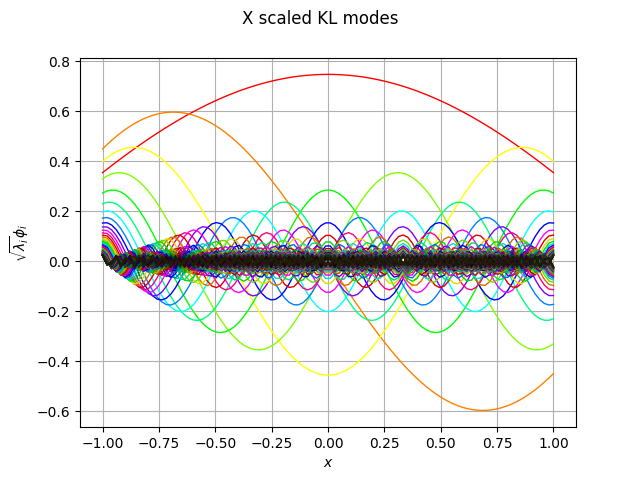

In [4]:
# Karhunen-Loeve decomposition of the input process
print("Compute the decomposition of the input process")
threshold = 0.0001
algo_X = ot.KarhunenLoeveP1Algorithm(mesh, process_X.getCovarianceModel(), threshold)
algo_X.run()
result_X = algo_X.getResult()
phi_X = result_X.getScaledModesAsProcessSample()
lambda_X = result_X.getEigenValues()

graph_modes_X, graph_ev_X = drawKL(phi_X, lambda_X, mesh, "X")
graph_modes_X


In [5]:
# Input database generation
print("Sample the input process")
size = 1000
sample_X = process_X.getSample(size)

Sample the input process


In [6]:
# The field model: convolution over an 1-d mesh
class ConvolutionP1(ot.OpenTURNSPythonFieldFunction):
    def __init__(self, p, mesh):
        # 1 = input dimension, the dimension of the input field
        # 1 = output dimension, the dimension of the output field
        # 1 = mesh dimension
        super(ConvolutionP1, self).__init__(mesh, 1, mesh, 1)
        # Here we define some constants and we set-up the invariant part of the execution
        self.setInputDescription(["x"])
        self.setOutputDescription(["y"])
        vertices = mesh.getVertices()
        size = vertices.getSize()
        self.mat_W_ = ot.SquareMatrix(size)
        for i in range(size):
            x_minus_t = (vertices - vertices[i]) * (-1.0)
            values_w = p(x_minus_t)
            for j in range(size):
                self.mat_W_[i, j] = values_w[j, 0]
        G = mesh.computeP1Gram()
        self.mat_W_ = self.mat_W_ * G
        
    def _exec(self, X):
        point_X = [val[0] for val in X]
        values_Y = self.mat_W_ * point_X
        return [[v] for v in values_Y]

In [7]:
# Dynamical model: convolution wrt kernel p
print("Create the convolution function")
p = ot.SymbolicFunction("x", "exp(-(x/" + str(h) + ")^2)")
myConvolution = ot.FieldFunction(ConvolutionP1(p, mesh))

Create the convolution function


In [8]:
# Output database generation
print("Sample the output process")
sample_Y = myConvolution(sample_X)

Sample the output process


Compute the decomposition of the output process


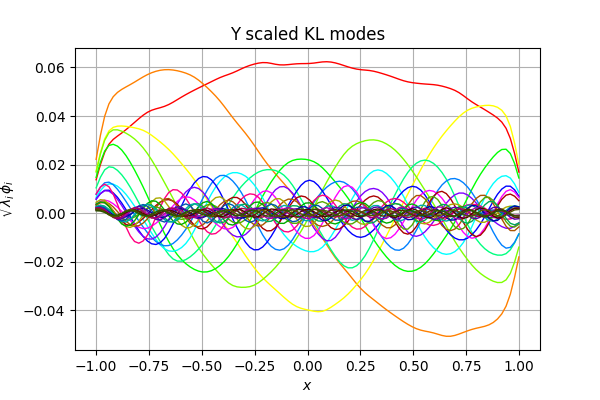

In [9]:
# Karhunen-Loeve decomposition of the output process
print("Compute the decomposition of the output process")
algo_Y = ot.KarhunenLoeveSVDAlgorithm(sample_Y, threshold)
algo_Y.run()
result_Y = algo_Y.getResult()
phi_Y = result_Y.getScaledModesAsProcessSample()
lambda_Y = result_Y.getEigenValues()
graph_modes_Y, graph_ev_Y = drawKL(phi_Y, lambda_Y, mesh, "Y")
graph_modes_Y

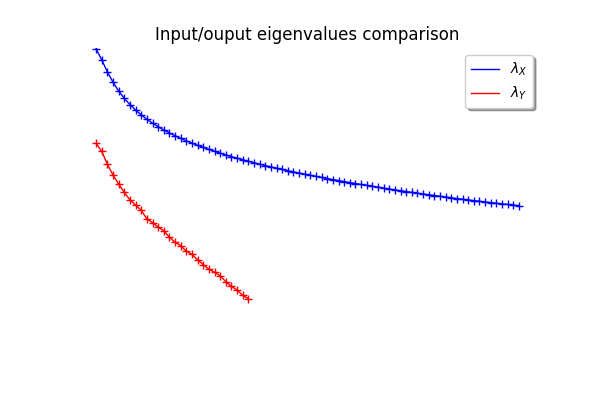

In [10]:
# Compare eigenvalues of X and Y
graph = ot.Graph(graph_ev_X)
graph.add(graph_ev_Y)
graph.setTitle("Input/ouput eigenvalues comparison")
graph.setYTitle(r"$\lambda_X, \lambda_Y$")
graph.setColors(["blue", "blue", "red", "red"])
graph.setLegends([r"$\lambda_X$", "", r"$\lambda_Y$", ""])
graph.setLegendPosition("topright")
graph

In [11]:
# Polynomial chaos between KL coefficients
print("project sample_X")
sample_xi_X = result_X.project(sample_X)

print("project sample_Y")
sample_xi_Y = result_Y.project(sample_Y)

print("Compute PCE between coefficients")
degree = 1
dimension_xi_X = sample_xi_X.getDimension()
dimension_xi_Y = sample_xi_Y.getDimension()
enumerateFunction = ot.LinearEnumerateFunction(dimension_xi_X)
basis = ot.OrthogonalProductPolynomialFactory(
        [ot.HermiteFactory()] * dimension_xi_X, enumerateFunction)
basisSize = enumerateFunction.getStrataCumulatedCardinal(degree)
adaptive = ot.FixedStrategy(basis, basisSize)
projection = ot.LeastSquaresStrategy(
        ot.LeastSquaresMetaModelSelectionFactory(ot.LARS(), ot.CorrectedLeaveOneOut()))
ot.ResourceMap.SetAsScalar("LeastSquaresMetaModelSelection-ErrorThreshold", 1.0e-7)
algo_chaos = ot.FunctionalChaosAlgorithm(sample_xi_X, sample_xi_Y, basis.getMeasure(), adaptive, projection)
algo_chaos.run()
result_chaos = algo_chaos.getResult()
meta_model = result_chaos.getMetaModel()
print("myConvolution=", myConvolution.getInputDimension(), "->", myConvolution.getOutputDimension())
preprocessing = ot.KarhunenLoeveProjection(result_X)
print("preprocessing=", preprocessing.getInputDimension(), "->", preprocessing.getOutputDimension())
print("meta_model=", meta_model.getInputDimension(), "->", meta_model.getOutputDimension())
postprocessing = ot.KarhunenLoeveLifting(result_Y)
print("postprocessing=", postprocessing.getInputDimension(), "->", postprocessing.getOutputDimension())
meta_model_field = ot.FieldToFieldConnection(postprocessing, ot.FieldToPointConnection(meta_model, preprocessing))


project sample_X
project sample_Y
Compute PCE between coefficients
myConvolution= 1 -> 1
preprocessing= 1 -> 76
meta_model= 76 -> 28
postprocessing= 28 -> 1


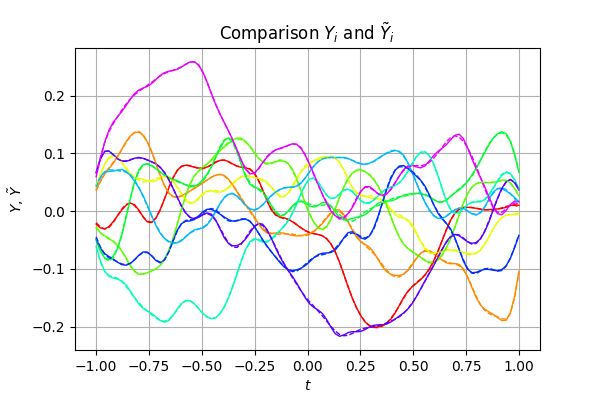

In [12]:
# Meta_model validation
iMax = 10
sample_X_validation = process_X.getSample(iMax)
sample_Y_validation = myConvolution(sample_X_validation)

graph_sample_Y_validation = sample_Y_validation.drawMarginal(0)
sample_Y_hat = meta_model_field(sample_X_validation)
graph = sample_Y_hat.drawMarginal(0)
for i in range(iMax):
    dr = graph.getDrawable(i)
    dr.setLineStyle("dashed")
    graph_sample_Y_validation.add(dr)
graph_sample_Y_validation.setTitle(r"Comparison $Y_i$ and $\tilde{Y}_i$")
graph_sample_Y_validation.setXTitle(r"$t$")
graph_sample_Y_validation.setYTitle(r"$Y$, $\tilde{Y}$")
graph_sample_Y_validation

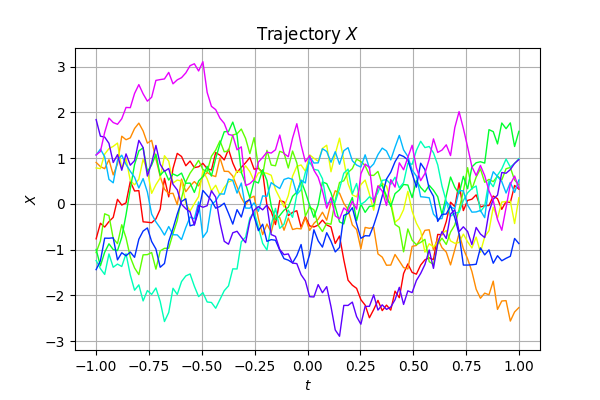

In [13]:
graph_sample_X = sample_X_validation.drawMarginal(0)
graph_sample_X.setTitle(r"Trajectory $X$")
graph_sample_X.setXTitle(r"$t$")
graph_sample_X.setYTitle(r"$X$")
graph_sample_X

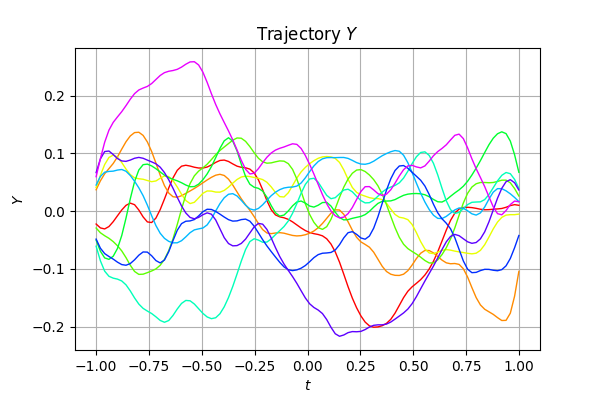

In [14]:
graph_sample_Y = sample_Y_validation.drawMarginal(0)
graph_sample_Y.setTitle(r"Trajectory $Y$")
graph_sample_Y.setXTitle(r"$t$")
graph_sample_Y.setYTitle(r"$Y$")
graph_sample_Y